In [2]:
import mlflow

In [12]:

from frodo.quickstart import *

import numpy as np
import torch


t = np.ones((3,4,4))
t[0, 1:3,1:3] = 0
t[1, 2:4,1:3] = 2
t[2, 0:2,1:3] = 0
print(np.mean(t, axis=(1,2)))
non_ignore = t == np.expand_dims(np.array([0,2,0]), list(range(1, t.ndim)))
t = np.ma.masked_array(t, non_ignore)
print(np.mean(t, axis=(1,2)))


[0.75 1.25 0.75]
[1.0 1.0 1.0]


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


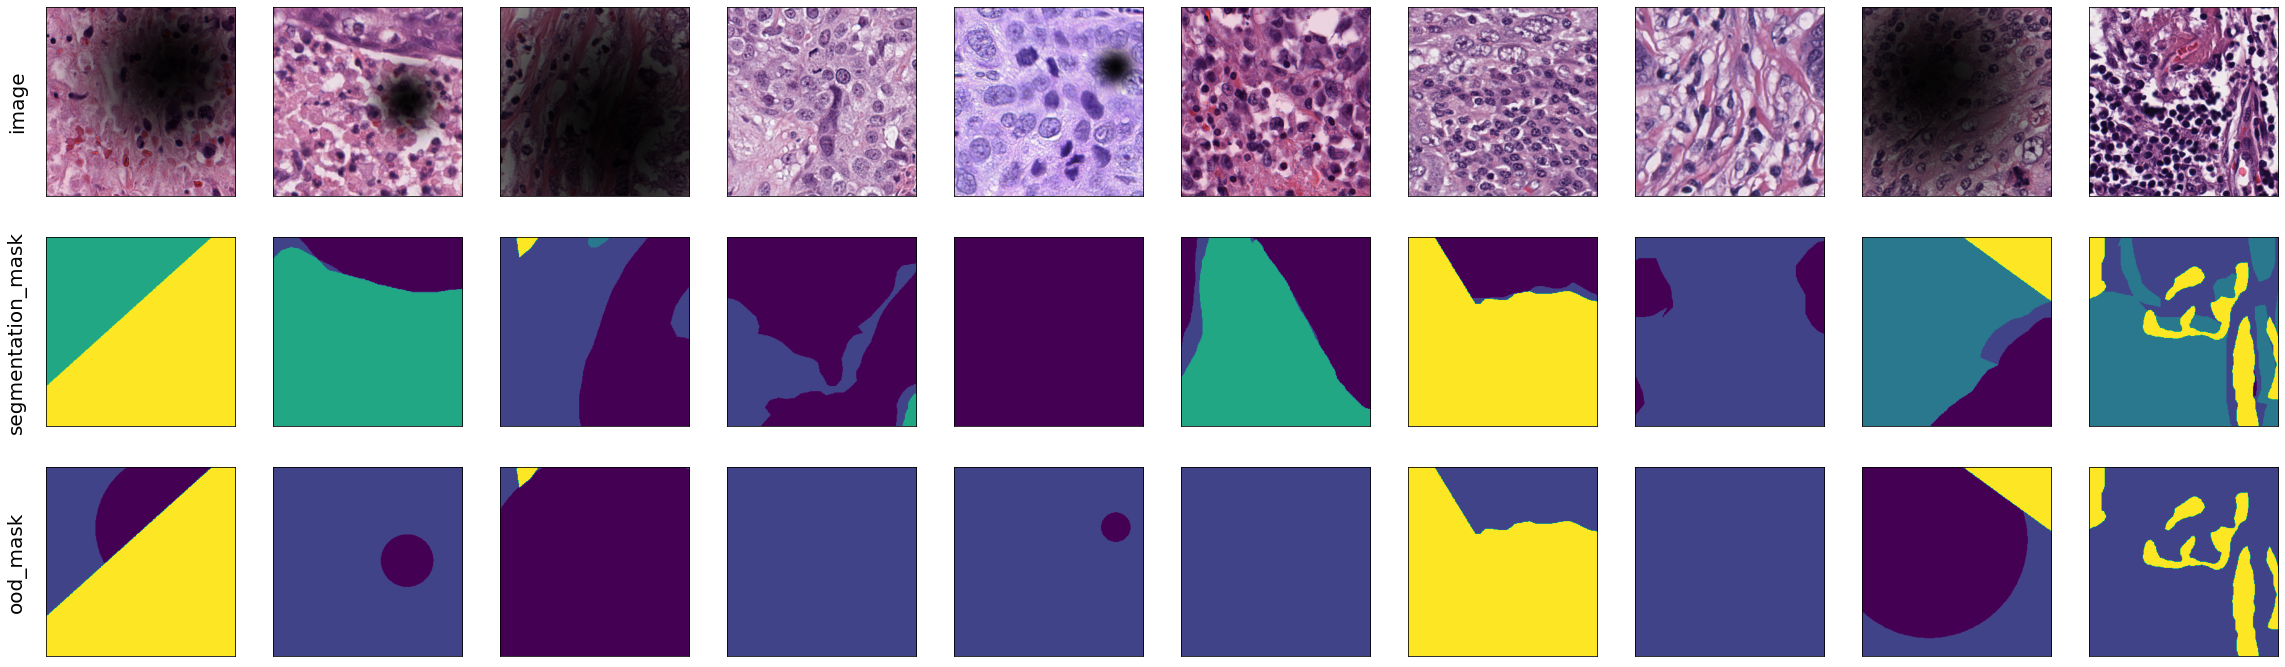

OOD Evaluation:   0%|          | 0/134 [00:00<?, ?it/s]c:\Users\jstieber\AppData\Local\conda\conda\envs\ssl4uc\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
OOD Evaluation: 100%|██████████| 134/134 [01:37<00:00,  1.38it/s]


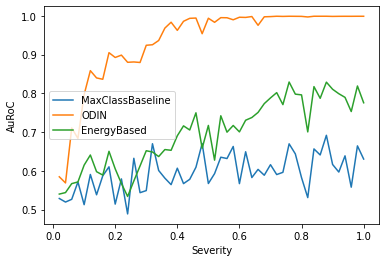

Name                             AUC
--------------------------  --------
MaxClassBaseline no params  0.579967
ODIN temp: 2, noise: 0.05   0.868154
EnergyBased temp: 1         0.663358


'\n\ncomponent = DatasetOODEvaluationComponent(\n    [BCSS_Adapted_Cropped_Resized_Datasets().val],\n    [BCSS_Adapted_Cropped_Resized_Datasets().test],\n    net,\n    seed=4321\n)\n\ncomponent()\n'

In [1]:
from frodo.models.segmentation import SegmentationModel
from frodo.data.datasets.examples.bcss import (
    BCSS_OOD_Dataset,
    BCSS_Base_Dataset,
    BCSS_Adapted_Datasets,
    BCSS_Adapted_Cropped_Resized_Datasets,
)
from frodo.data.datasets.interfaces import OODDataset
from frodo.ood.augmentations import *
from frodo.data.metadata import SampleMetadataCommonTypes
from frodo.data.container import MetadataContainer
from frodo.ood.metrics import OODAuRoC, infer_container
from frodo.ood.strategies import AugmentationStrategy, OODDatasetsStrategy
from frodo.ood.methods import ODIN, EnergyBased, MaxClassBaseline
from frodo.ood.augmentations.utility.pipeline import SizeInOODPipeline
from frodo.ood.augmentations.indistribution import InResize, InCrop
from frodo.ood.augmentations.pathology.deforming import OverlapAugmentation
from frodo.experiment.components.examples import (
    AugmentationOODEvaluationComponent,
    DatasetOODEvaluationComponent,
)
from frodo.data.datasets.adapter import AlreadyASampleAdapter
from frodo.ood.augmentations.pathology.artifacts.blood_group import (
    BloodGroupAugmentation,
)

import matplotlib.pyplot as plt
import tqdm
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, ConcatDataset


net = SegmentationModel().load()
metrics = [OODAuRoC(group_by="bin", num_bins=50), OODAuRoC()]


component = AugmentationOODEvaluationComponent(
    BCSS_Adapted_Cropped_Resized_Datasets().test,
    SampledOODAugmentation(DarkSpotsAugmentation()),
    net,
    metrics=metrics,
    seed=4321,
)


component()

"""

component = DatasetOODEvaluationComponent(
    [BCSS_Adapted_Cropped_Resized_Datasets().val],
    [BCSS_Adapted_Cropped_Resized_Datasets().test],
    net,
    seed=4321
)

component()
"""


In [ ]:
d = OODAugmentationDataset(
    # BCSS_Adapted_Cropped_Resized_Datasets().test,
    BCSS_Adapted_Datasets(size=(800, 800)).test,
    SizeInOODPipeline(
        size_augmentations=[OverlapAugmentation()],
        in_augmentations=[InCrop((600, 600)), InResize((300, 300))],
    ),
)

b = Batch.init_from_samples([d[0]])

print(b["ood_mask"])

non_ignore = b["ood_mask"] != torch.from_numpy(
    np.expand_dims(
        np.array(b.metadata["ignore_index"]),
        list(range(1, b["ood_mask"].ndim)),
    )
)
plt.imshow(non_ignore[0])
plt.show()
d[0].plot()

In [13]:
t = component.get_artifacts()["metrics"][0]
np.array(list(t.metric.group_keys)) / (50) + 1/ 50

array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22,
       0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44,
       0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66,
       0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88,
       0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

In [10]:
import pickle
data = pickle.load(open("filename.pickle", "rb"))

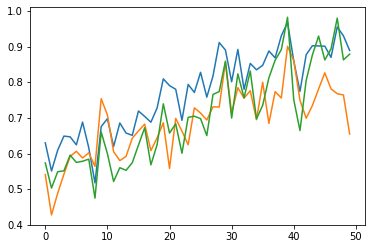

In [13]:
data.metric.present()

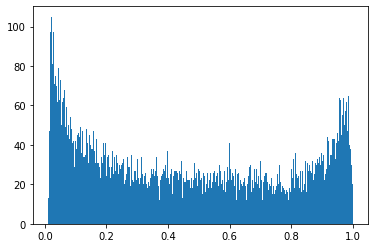

In [6]:
print(np.mean(score,tuple(range(1, score.ndim))))
all.extend(
[
    m["severity"].measurement
    for m in meta
    if m.type is DistributionSampleType.AUGMENTATION_OOD_DATA
] )

import numpy as np
plt.hist(all, 500)
plt.show()
